In [2]:
import pandas as pd

#type
train_df = pd.read_csv('../data/train_df.csv')
test_df = pd.read_csv('../data/test_df.csv')

In [3]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, classification_report

features = ['name_lower', 'type_lower', 'category_l2', 'category_l4', 'type_in_name', 'category_l2_was_null', 'category_l4_was_null']
cat_features = [0, 1, 2, 3]

X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.2,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=50,
    random_state=42
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)

0:	test: 0.9391624	best: 0.9391624 (0)	total: 1.08s	remaining: 5m 22s
50:	test: 0.9556877	best: 0.9556877 (50)	total: 17.2s	remaining: 1m 23s
100:	test: 0.9563741	best: 0.9563741 (100)	total: 28.4s	remaining: 56s
150:	test: 0.9566799	best: 0.9566799 (150)	total: 39.9s	remaining: 39.3s
200:	test: 0.9569312	best: 0.9569312 (200)	total: 51s	remaining: 25.1s
250:	test: 0.9570108	best: 0.9570137 (249)	total: 1m 2s	remaining: 12.2s
299:	test: 0.9570582	best: 0.9570582 (299)	total: 1m 14s	remaining: 0us

bestTest = 0.9570582074
bestIteration = 299



In [4]:
y_pred_proba = model.predict_proba(test_pool)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC на тесте: {roc_auc:.4f}')
print(classification_report(y_test, model.predict(X_test)))

ROC-AUC на тесте: 0.9571
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     94605
           1       0.97      0.82      0.89     90928

    accuracy                           0.90    185533
   macro avg       0.91      0.90      0.90    185533
weighted avg       0.91      0.90      0.90    185533



In [5]:
unique_types = train_df['type_lower'].unique()

def get_top_10_types(sample_row):
    candidate_rows = []
    for t in unique_types:
        row = sample_row.copy()
        row['type_lower'] = t
        row['type_in_name'] = int(t in row['name_lower'])
        candidate_rows.append(row)
    df_candidates = pd.DataFrame(candidate_rows)

    preds = model.predict_proba(df_candidates[features])[:, 1]
    top_10_idx = preds.argsort()[::-1][:10]
    top_10_types = df_candidates.iloc[top_10_idx][['type_lower']].copy()
    top_10_types['probability'] = preds[top_10_idx]
    return top_10_types.reset_index(drop=True)

# Пример ранжирования
sample = X_test.iloc[2457].copy()
top_10 = get_top_10_types(sample)
print(X_test.iloc[2457])
print(top_10)

name_lower              коврики в салон 5 шт. для киа соренто прайм 20...
type_lower                                     коврики в салон автомобиля
category_l2                                                    Автотовары
category_l4                                    Коврики в салон автомобиля
type_in_name                                                        False
category_l2_was_null                                                False
category_l4_was_null                                                False
Name: 2457, dtype: object
                            type_lower  probability
0           коврики в салон автомобиля     0.989825
1                                    0     0.982956
2                    коврик в багажник     0.845909
3              навигатор автомобильный     0.640991
4        стойка/крепление для акустики     0.640991
5  пластик, обтекатели для мототехники     0.640991
6                    украшение для яиц     0.640991
7              бад для головного мозга  

In [6]:
feature_importances = model.get_feature_importance(train_pool)
for name, score in zip(features, feature_importances):
    print(f"{name}: {score:.3f}")

name_lower: 17.068
type_lower: 18.401
category_l2: 6.497
category_l4: 18.244
type_in_name: 33.859
category_l2_was_null: 1.317
category_l4_was_null: 4.613


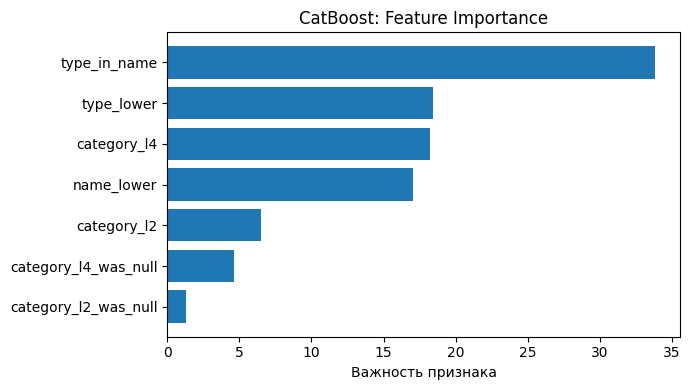

In [7]:
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=True)

plt.figure(figsize=(7, 4))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Важность признака')
plt.title('CatBoost: Feature Importance')
plt.tight_layout()
plt.show()

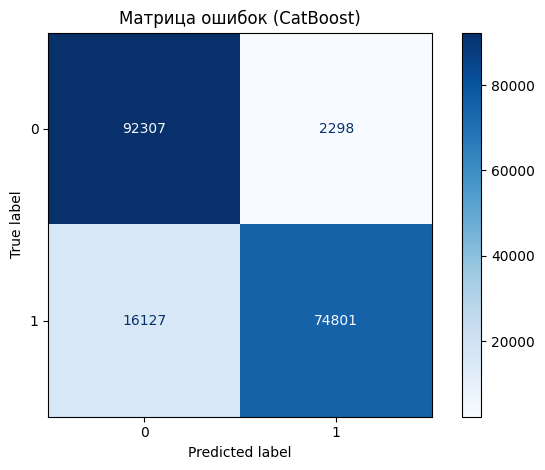

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_pool)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Матрица ошибок (CatBoost)')
plt.tight_layout()
plt.show()